In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from skimage.transform import resize
from pathlib import Path

In [2]:
cols = ['Age', 'Sex', 'PositivityAtAdmission', 'Temp_C', 'DaysFever', 'Cough',
       'DifficultyInBreathing', 'WBC', 'RBC', 'CRP', 'Fibrinogen', 'Glucose',
       'PCT', 'LDH', 'INR', 'D_dimer', 'Ox_percentage', 'PaO2', 'SaO2',
       'PaCO2', 'pH', 'CardiovascularDisease', 'IschemicHeartDisease',
       'AtrialFibrillation', 'HeartFailure', 'Ictus', 'HighBloodPressure',
       'Diabetes', 'Dementia', 'BPCO', 'Cancer', 'ChronicKidneyDisease',
       'RespiratoryFailure', 'Obesity', 'Position']

In [3]:
test_mean_mild_map = np.load(
    "../data/raw_output/checkpoints_xplainable/ES_2022-10-03_15:27:54.457214/attentions/mean_mild_attentions.npy")
test_mean_severe_map = np.load(
    "../data/raw_output/checkpoints_xplainable/ES_2022-10-03_15:27:54.457214/attentions/mean_severe_attentions.npy")

mean_mild_map = np.load(
    "../data/raw_output/checkpoints_xplainable/ES_2022-10-03_15:27:54.457214/attentions/valid_mean_mild_attentions.npy")
mean_severe_map = np.load(
    "../data/raw_output/checkpoints_xplainable/ES_2022-10-03_15:27:54.457214/attentions/valid_mean_severe_attentions.npy")

In [4]:
mean_mild_map.shape, mean_severe_map.shape, test_mean_mild_map.shape, test_mean_severe_map.shape

((256, 35, 1), (256, 35, 1), (256, 35, 1), (256, 35, 1))

In [5]:
def reshape(inp):
    return np.moveaxis(inp.reshape(16, 16, 35), 2, 0)

mean_mild_map = reshape(mean_mild_map)
mean_severe_map = reshape(mean_severe_map)
test_mean_mild_map = reshape(test_mean_mild_map)
test_mean_severe_map = reshape(test_mean_severe_map)

mean_mild_map.shape

(35, 16, 16)

In [6]:
brixia_scores = np.array(
    [np.loadtxt(
        fname
    ).reshape(3, 2).astype(int) for fname in Path(
        "../data/preprocessed_data/train/score_original/").glob("*.txt")])


brixia_paths = np.array(
    [fname.name for fname in Path(
        "../data/preprocessed_data/train/score_original/").glob("*.txt")]).tolist()

len(brixia_scores), len(brixia_paths), len(np.unique(brixia_paths))

(1103, 1103, 1103)

In [7]:
test_brixia_scores = np.array(
    [np.loadtxt(
        fname
    ).reshape(3, 2).astype(int) for fname in Path(
        "../data/preprocessed_data/test/score_original/").glob("*.txt")])

test_brixia_paths = np.array(
    [fname.name for fname in Path(
        "../data/preprocessed_data/test/score_original/").glob("*.txt")]).tolist()

len(test_brixia_scores), len(test_brixia_paths), len(np.unique(test_brixia_paths))

(486, 486, 486)

In [8]:
prognosis = pd.read_csv(
    "../data/preprocessed_data/tables/trainClinData.csv"
)["Prognosis"].map(lambda x: int(x == "SEVERE")).values
test_prognosis = pd.read_excel(
    "../data/raw_data/completeTestClinData.xls"
)["Prognosis"].map(lambda x: int(x == "SEVERE")).values

names = pd.read_csv(
    "../data/preprocessed_data/tables/trainClinData.csv"
)["ImageFile"].map(lambda x: x.replace('.png', '.txt')).values.tolist()
test_names = pd.read_csv(
    "../data/preprocessed_data/tables/testClinData.csv"
)["ImageFile"].map(lambda x: x.replace('.png', '.txt')).values.tolist()

In [9]:
len(names), len(test_names), len(brixia_paths), len(test_brixia_paths)

(1103, 486, 1103, 486)

In [10]:
names[:5], test_names[:5], brixia_paths[:5], test_brixia_paths[:5]

(['P_102.txt', 'P_131.txt', 'P_132.txt', 'P_117.txt', 'P_16.txt'],
 ['P_3_29.txt', 'P_3_415.txt', 'P_3_163.txt', 'P_3_348.txt', 'P_3_263.txt'],
 ['P_1_27.txt', 'P_272.txt', 'P_613.txt', 'P_165.txt', 'P_504.txt'],
 ['P_3_442.txt', 'P_3_334.txt', 'P_3_493.txt', 'P_3_399.txt', 'P_3_348.txt'])

In [11]:
prognosis[:5], test_prognosis[:5]

(array([1, 0, 0, 0, 1]), array([0, 0, 0, 1, 1]))

In [12]:
def sort_indicies(x, y):
    x = np.array(x)
    y = np.array(y)
    xsorted = np.argsort(x)
    ypos = np.searchsorted(x[xsorted], y)
    indices = xsorted[ypos]
    return indices

indices = sort_indicies(brixia_paths, names)
test_indices = sort_indicies(test_brixia_paths, test_names)

indices[:5], test_indices[:5]

(array([896, 645, 490,  59, 462]), array([237, 219, 104,   4, 156]))

In [14]:
print(names[:7], '\n', np.array(brixia_paths)[indices][:7].tolist())
print('')
print(test_names[:7], '\n', np.array(test_brixia_paths)[test_indices][:7].tolist())

['P_102.txt', 'P_131.txt', 'P_132.txt', 'P_117.txt', 'P_16.txt', 'P_118.txt', 'P_195.txt'] 
 ['P_102.txt', 'P_131.txt', 'P_132.txt', 'P_117.txt', 'P_16.txt', 'P_118.txt', 'P_195.txt']

['P_3_29.txt', 'P_3_415.txt', 'P_3_163.txt', 'P_3_348.txt', 'P_3_263.txt', 'P_3_89.txt', 'P_3_435.txt'] 
 ['P_3_29.txt', 'P_3_415.txt', 'P_3_163.txt', 'P_3_348.txt', 'P_3_263.txt', 'P_3_89.txt', 'P_3_435.txt']


In [15]:
mean_severe_brixia_scores = brixia_scores[indices][np.nonzero(prognosis)]
mean_mild_brixia_scores = brixia_scores[indices][np.nonzero(1. - prognosis)]


test_mean_severe_brixia_scores = test_brixia_scores[test_indices
                                                   ][np.nonzero(test_prognosis)]
test_mean_mild_brixia_scores = test_brixia_scores[test_indices
                                                 ][np.nonzero(1. - test_prognosis)]

def mean_interpolate(arr):
    rescaled = []
    for _arr in arr:
        out = resize(_arr, (16, 16), preserve_range=True)
        rescaled.append(out)
    br_map = np.mean(np.array(rescaled), axis=0)
    br_map = (br_map - np.mean(br_map))/np.std(br_map)
    return br_map

test_mean_severe_brixia_scores = mean_interpolate(test_mean_severe_brixia_scores)
test_mean_mild_brixia_scores = mean_interpolate(test_mean_mild_brixia_scores)

mean_severe_brixia_scores = mean_interpolate(mean_severe_brixia_scores)
mean_mild_brixia_scores = mean_interpolate(mean_mild_brixia_scores)

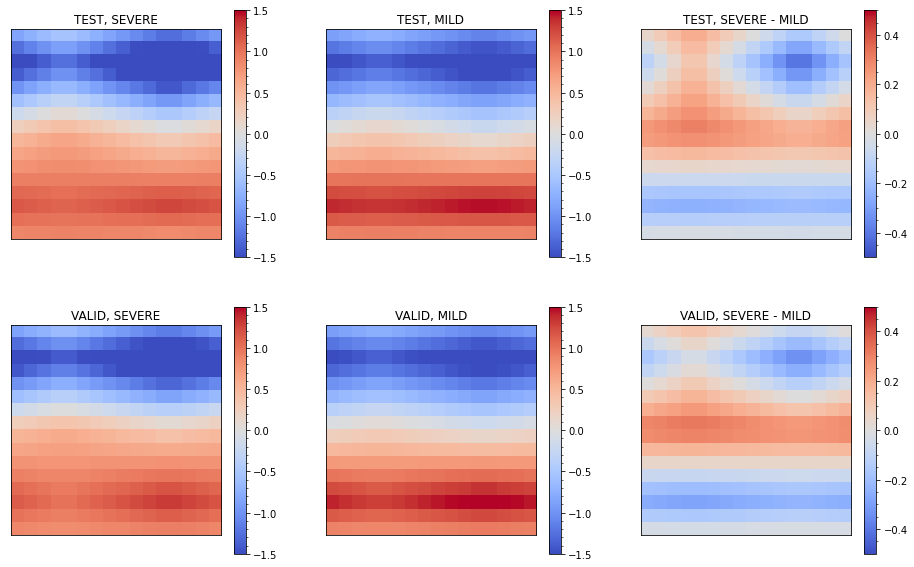

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes = axes.flatten()

cdata = axes[0].imshow(test_mean_severe_brixia_scores, vmin=-1.5, vmax=1.5, interpolation='none', cmap='coolwarm')
axes[0].set_title('TEST, SEVERE')
cbar = plt.colorbar(cdata, ax=axes[0])
cbar.minorticks_on()
axes[0].set_xticks([])
axes[0].set_yticks([])

cdata = axes[1].imshow(test_mean_mild_brixia_scores, vmin=-1.5, vmax=1.5, interpolation='none', cmap='coolwarm')
axes[1].set_title('TEST, MILD')
cbar = plt.colorbar(cdata, ax=axes[1])
cbar.minorticks_on()
axes[1].set_xticks([])
axes[1].set_yticks([])

cdata = axes[2].imshow(test_mean_severe_brixia_scores - test_mean_mild_brixia_scores, vmin=-.5, vmax=.5, interpolation='none', cmap='coolwarm')
axes[2].set_title('TEST, SEVERE - MILD')
cbar = plt.colorbar(cdata, ax=axes[2])
cbar.minorticks_on()
axes[2].set_xticks([])
axes[2].set_yticks([])

cdata = axes[3].imshow(mean_severe_brixia_scores, vmin=-1.5, vmax=1.5, interpolation='none', cmap='coolwarm')
axes[3].set_title('VALID, SEVERE')
cbar = plt.colorbar(cdata, ax=axes[3])
cbar.minorticks_on()
axes[3].set_xticks([])
axes[3].set_yticks([])

cdata = axes[4].imshow(mean_mild_brixia_scores, vmin=-1.5, vmax=1.5, interpolation='none', cmap='coolwarm')
axes[4].set_title('VALID, MILD')
cbar = plt.colorbar(cdata, ax=axes[4])
cbar.minorticks_on()
axes[4].set_xticks([])
axes[4].set_yticks([])

cdata = axes[5].imshow(mean_severe_brixia_scores - mean_mild_brixia_scores, vmin=-.5, vmax=.5, interpolation='none', cmap='coolwarm')
axes[5].set_title('VALID, SEVERE - MILD')
cbar = plt.colorbar(cdata, ax=axes[5])
cbar.minorticks_on()
axes[5].set_xticks([])
axes[5].set_yticks([])

plt.show()

In [17]:
def correlation_study(arr, brixia, cols, threshold=0.0):
    data = []
    for _arr, _col in zip(arr, cols):
        _arr = (_arr - np.mean(_arr.flatten()))/np.std(_arr.flatten())
        # (1, 1)
        ARR = _arr[:5, :8]
        BRX = brixia[:5, :8]
        corr1 = np.cov(ARR.flatten(), BRX.flatten())[0, 1]
        # (1, 2)
        ARR = _arr[:5, 8:]
        BRX = brixia[:5, 8:]
        corr2 = np.cov(ARR.flatten(), BRX.flatten())[0, 1]
        # (2, 1)
        ARR = _arr[6:12, :8]
        BRX = brixia[6:12, :8]
        corr3 = np.cov(ARR.flatten(), BRX.flatten())[0, 1]
        # (2, 2)
        ARR = _arr[6:12, 8:]
        BRX = brixia[6:12, 8:]
        corr4 = np.cov(ARR.flatten(), BRX.flatten())[0, 1]
        # (3, 1)
        ARR = _arr[12:, :8]
        BRX = brixia[12:, :8]
        corr5 = np.cov(ARR.flatten(), BRX.flatten())[0, 1]
        # (3, 2)
        ARR = _arr[12:, 8:]
        BRX = brixia[12:, 8:]
        corr6 = np.cov(ARR.flatten(), BRX.flatten())[0, 1]
        
        corr = np.array([corr1, corr2, corr3, corr4, corr5, corr6]).reshape(3, 2)
        if np.max(np.abs(corr)) > threshold:
            data.append((_col, corr))
    data = sorted(data, key=lambda x: np.max(np.abs(x[1])), reverse=True)
    fig, axes = plt.subplots(2, 5, figsize=(20, 5))
    axes = axes.flatten()
    for dp, ax in zip(data, axes):
        ax.set_title(dp[0])
        maxi = np.max(np.abs(dp[1]))
        data = ax.imshow(dp[1], vmin=-maxi, vmax=maxi, cmap='coolwarm')
        plt.colorbar(data, ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# TEST

### TEST - MILD

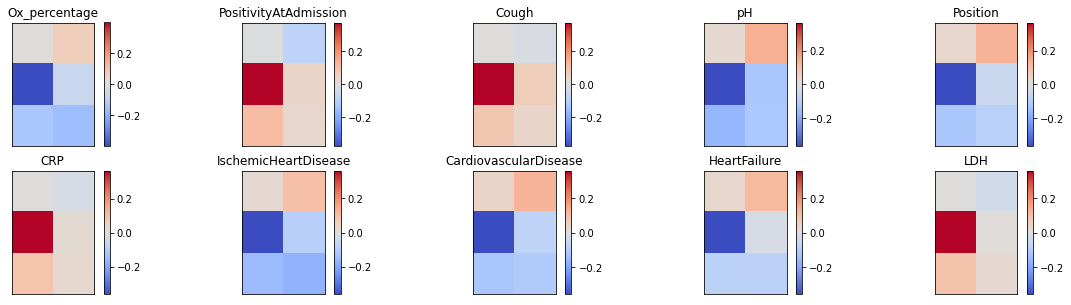

In [18]:
correlation_study(test_mean_mild_map, test_mean_mild_brixia_scores, cols, 0.3)

### TEST - SEVERE

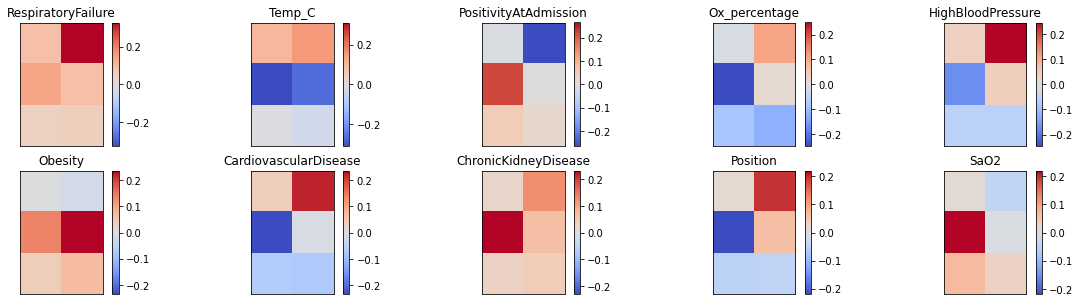

In [19]:
correlation_study(test_mean_severe_map, test_mean_severe_brixia_scores, cols, 0.2)

### TEST, SEVERE - MILD

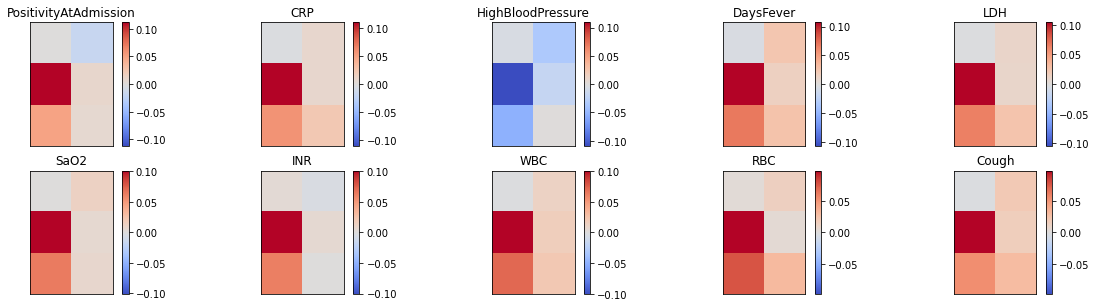

In [20]:
correlation_study(test_mean_severe_map - test_mean_mild_map,
                  test_mean_severe_brixia_scores - test_mean_mild_brixia_scores,
                  cols, 0.05)

# VALID

## VALID - MILD

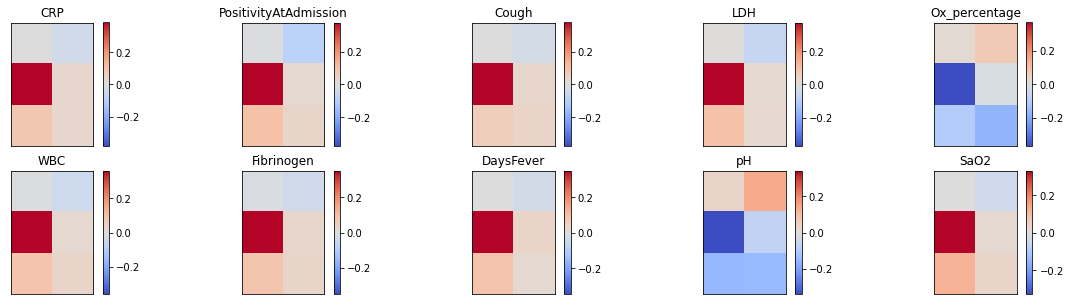

In [21]:
correlation_study(mean_mild_map, mean_mild_brixia_scores, cols, 0.3)

## VALID - SEVERE

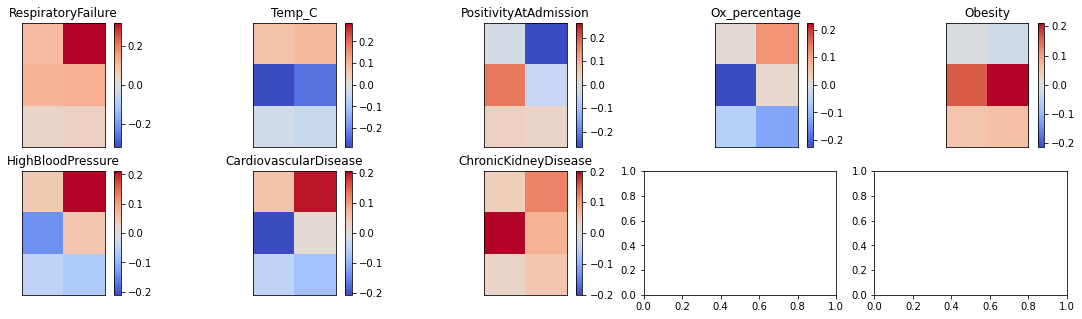

In [22]:
correlation_study(mean_severe_map, mean_severe_brixia_scores, cols, 0.2)

## VALID, SEVERE - MILD

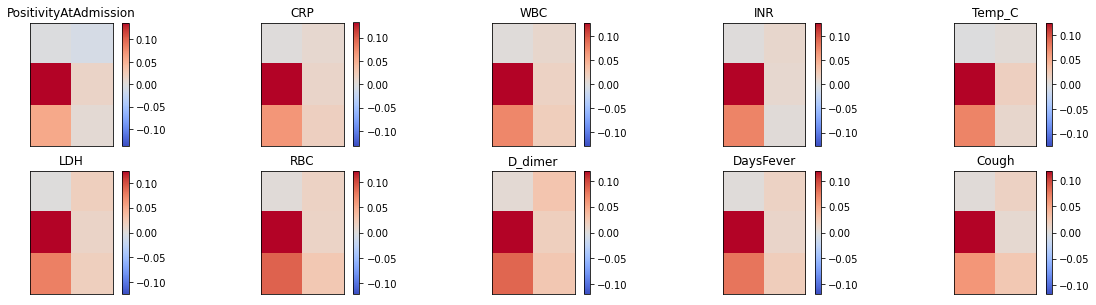

In [23]:
correlation_study(mean_severe_map - mean_mild_map,
                  mean_severe_brixia_scores - mean_mild_brixia_scores,
                  cols, 0.05)